# imitools Dev

The devtool for imitools.

## Todo

* ~Introduce the wrap & from_path funtions~
* convert the codebase to keep a list of pils
* support loading files from directories
* add a map function
* save a wrap to a disk (directory)
* create a video from a disk
    * get a filepath
    * show it

## Later

* Add Multi Threading support
* Download images from duckduck go

In [6]:
device = "cuda"

In [52]:
from __future__ import annotations

from PIL import Image
import torch
from torchvision import transforms
from matplotlib import pyplot as plt
import math
from IPython.display import  display

class ImageDefaults:
    def __init__(self):
        self.device = "cpu"
        
defaults = ImageDefaults()

class ImageWrapper:
    def __init__(self, data, image_type):
        self.data = data
        self.image_type = image_type
        
    def resize(self, size=(256, 256)) -> ImageWrapper:
        if isinstance(size, int):
            size = (size, size)
        
        return ImageWrapper(self.data.resize(size), "pil")
    
    def normalize(self) -> ImageWrapper:
        if self.image_type != "pt":
            raise Exception("normalize() only applied for pytorch tensors")
        
        normalized = (self.data - self.data.min()) / (self.data.max() - self.data.min())
        return ImageWrapper(normalized, "pt")
    
    def sinrange(self) -> ImageWrapper:
        if self.image_type != "pt":
            raise Exception("sinrange() only applied for pytorch tensors")
        
        return ImageWrapper(self.data * 2 - 1, "pt")
        
    def pil(self) -> Image:
        if self.image_type == "pil":
            return self.data
        
        if self.image_type == "pt":
            return transforms.ToPILImage()(self.data.squeeze(0).cpu())
    
    def pt(self) -> torch.Tensor:            
        if self.image_type == "pil":
            pt_image = transforms.ToTensor()(self.data)
            return pt_image.unsqueeze(0).to(defaults.device)
        
        if self.image_type == "pt":
            return self.data
        
    def to(self, device="cpu") -> ImageWrapper:
        if self.image_type != "pt":
            raise Exception("to() only applied for pytorch tensors")
        
        return ImageWrapper(self.data.to(device), "pt")
    
    def cpil(self) -> ImageWrapper:
        return ImageWrapper(self.pil(), "pil")
    
    def cpt(self) -> ImageWrapper:
        return ImageWrapper(self.pt(), "pt")
    
    def show(self, cmap=None, figsize=None, cols=6, max_count=36):        
        if self.image_type == "pil":
            plt.axis("off")
            plt.imshow(self.data, cmap=cmap)
            return
        
        if len(self.data) == 1:
            plt.axis("off")
            plt.imshow(self.data[0].permute(1, 2, 0).cpu(), cmap=cmap)
            return
        
        images = self.data.cpu()
        image_count = len(self.data)
        
        if image_count > max_count:
            images = self.data[0:max_count]
            print(f"found {image_count} images to show. But only showing {max_count}")
            
        if image_count < cols:
            cols = image_count
            
        rows = math.ceil(image_count / cols)
        
        if figsize == None:
            figsize = figsize=(cols*2.5, rows*2.5)
            
        _, ax = plt.subplots(rows, cols, figsize=figsize)
        if (rows == 1):
            for i in range(image_count):
                ax[i].imshow(images[i].permute(1, 2, 0))
                ax[i].axis("off")   
                ax[i].set_title(f"{i}")
        else:
            for row in range(rows):
                for col in range(cols):
                    i = row * cols + col
                    if i < image_count:
                        ax[row][col].imshow(images[i].permute(1, 2, 0))
                        ax[row][col].axis("off")
                        ax[row][col].set_title(f"{i}")
                    else:
                        ax[row][col].axis("off")

def wrap(input_data) -> ImageWrapper:
    if isinstance(input_data, ImageWrapper):
        return input_data
    
    if isinstance(input_data, torch.Tensor):
        if len(input_data.shape) == 3:
            input_data = input_data.unsqueeze(0)
            
        return ImageWrapper(input_data, "pt")
    
    if isinstance(input_data, list):
        if isinstance(input_data[0], torch.Tensor):
            images = torch.stack(input_data).squeeze(1)
            return ImageWrapper(images, "pt")
        
        if isinstance(input_data[0], ImageWrapper):
            image_list = list(map(lambda w: w.pt(), input_data))
            images = torch.stack(image_list).squeeze(1)
            return ImageWrapper(images, "pt")
    
    raise Exception("not implemented!")                        
                        
def from_path(input_data) -> ImageWrapper:
    pil_image = Image.open(input_data).convert("RGB")
    return ImageWrapper(pil_image, "pil")
                        

class DynaPlot:
    def __init__(self, cols=2, figsize=(15, 4)):
        fig, subplots = plt.subplots(1, cols, figsize=(20, 5))
        fig.patch.set_facecolor("white")
        fig.tight_layout()
        out = display(fig, display_id=True)

        self.cols = cols
        self.fig = fig
        self.out = out
        self.subplots = subplots
        
        self.queue = []
        
    def plot(self, subplot_id, *args, **kwargs) -> DynaPlot:
        self.queue.append((
            "plot", subplot_id, args, kwargs
        ))
        return self
    
    def title(self, subplot_id, title)-> DynaPlot:
        self.queue.append((
            "title", subplot_id, title
        ))
        return self
        
    def imshow(self, subplot_id, image)-> DynaPlot:
        self.queue.append((
            "imshow", subplot_id, image
        ))
        return self
        
    def update(self):
        for col in range(self.cols):
            if self.cols == 1:
                self.subplots.clear()
            else:
                self.subplots[col].clear()
        
        for item in self.queue:
            if item[0] == "imshow":
                _, subplot_id, image = item
                if self.cols == 1:
                    self.subplots.imshow(wrap(image).pt().detach().cpu()[0].permute(1, 2, 0))
                    self.subplots.axis("off")
                else:
                    self.subplots[subplot_id].imshow(wrap(image).pt().detach().cpu()[0].permute(1, 2, 0))
                    self.subplots[subplot_id].axis("off")
            
            if item[0] == "plot":
                _, subplot_id, args, kwargs = item
                self.subplots[subplot_id].plot(*args, **kwargs)
                if "label" in kwargs:
                    self.subplots[subplot_id].legend()
                
            if item[0] == "title":
                _, subplot_id, title = item
                self.subplots[subplot_id].title.set_text(title)
                
        self.queue = []
        self.out.update(self.fig)
        
    def close(self):
        self.update()
        plt.close()
    
def dplot(**kwargs) -> DynaPlot:
    return DynaPlot(**kwargs)

class ImiTools:
    def __init__(self):
        self.defaults = defaults
        
    def wrap(self, path) -> ImageWrapper:
        return wrap(path)
                        
    def from_path(self, path) -> ImageWrapper:
        return from_path(path)
    
    def dplot(self, **kwargs) -> DynaPlot:
        return dplot(**kwargs)
    
I = ImiTools()
I.defaults.device = device

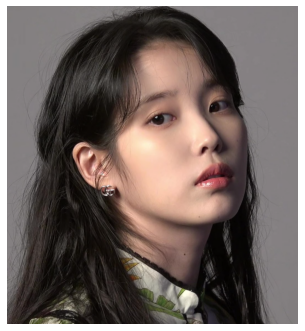

In [54]:
iu = I.from_path("./images/iu.png")
dp = I.dplot(cols=1)
dp.imshow(0, iu)
dp.close()